In [3]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd 
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#%matplotlib inline
import matplotlib 
#matplotlib.use('TKAgg')
%matplotlib inline

In [4]:
from hessian import hessian

In [5]:
import sys
sys.path.append('../adversarial/')
sys.path.append('../architectures/')

In [6]:
import matplotlib.pyplot as plt

In [7]:
from mpl_toolkits.mplot3d import Axes3D

In [8]:
from torch import nn

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from torchvision import transforms, datasets
import torch
from net_mnist import Net, NetSoft, model_cnn

In [10]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [11]:
transform = transforms.ToTensor()
train = datasets.MNIST('../../data/MNIST', train=True, transform=transform, download=True)
val = datasets.MNIST('../../data/MNIST', train=False, transform=transform, download=True)

In [12]:
Xtens = torch.zeros([10000,1,28,28])
y = torch.zeros([10000])

for i in range(len(val)):
    Xtens[i,:,:,:],y[i] = val[i]

In [13]:
X = Xtens.view(-1,784)

## PCA

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
pc1 = pca_result[:,0]
pc2 = pca_result[:,1] 
pc3 = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
#Explained variation per principal component: [0.09730166 0.07135901 0.06183721]

In [14]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.289s...
[t-SNE] Computed neighbors for 10000 samples in 115.124s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.129212
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.917961
[t-SNE] Error after 300 iterations: 2.780396
t-SNE done! Time elapsed: 169.7

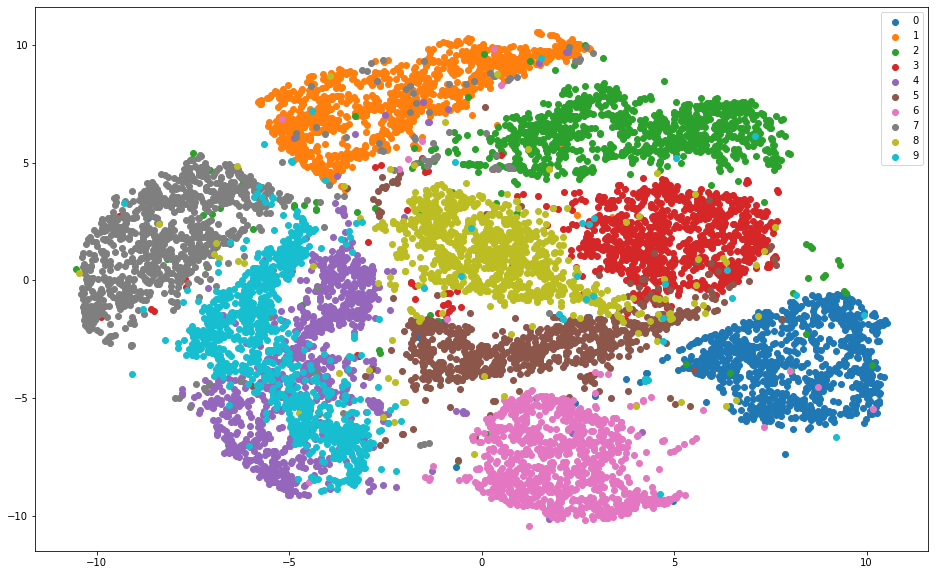

In [15]:
ts1 = tsne_results[:,0]
ts2 = tsne_results[:,1]
plt.figure(figsize=(16,10))
leg= []
for i in range(10):    
    ind = torch.where(y==i)
    plt.scatter(ts1[ind], ts2[ind], marker='o')
    leg.append(str(i))
plt.legend(leg)

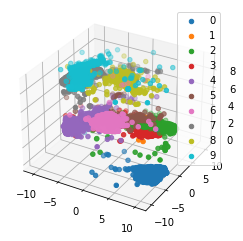

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(10):    
    ind = torch.where(y==i)
    ax.scatter(xs=ts1[ind], ys=ts2[ind], zs=i)
                   
plt.legend(leg)                   

In [17]:
Net = model_cnn
NetName = 'model_cnn'

In [18]:
Net_AT = torch.load('../trainedmodels/MNIST/model_cnn_AT2_ep12_lr0.1.pt')
Net_AT = Net_AT.to('cuda')

In [19]:
Net_SGD = torch.load('../trainedmodels/MNIST/model_cnn_SGD_ep50_lr0.1.pt')

In [20]:
loss_fn = nn.CrossEntropyLoss()

In [21]:
ypred1 = Net_SGD(Xtens.to('cuda'))
ypred2 = Net_AT(Xtens.to('cuda'))

In [22]:
y = y.long().to('cuda')

In [23]:
torch.sum(torch.argmax(ypred2,dim=1)==y)/10000.

tensor(0.9745, device='cuda:0')

In [24]:
torch.sum(torch.argmax(ypred1,dim=1)==y)/10000.

tensor(0.9877, device='cuda:0')

In [25]:
loss_p_sample1 = []
loss_p_sample2 = []
acc1 = []
acc2 = []
for i in range(10000):
    loss_p_sample1.append(loss_fn(torch.unsqueeze(ypred1[i],0),torch.unsqueeze(y[i],0)))
    acc1.append(torch.argmax(ypred1[i])==y[i])
    loss_p_sample2.append(loss_fn(torch.unsqueeze(ypred2[i],0),torch.unsqueeze(y[i],0)))
    acc2.append(torch.argmax(ypred2[i])==y[i])

In [26]:
loss_p_sample1 = torch.tensor(loss_p_sample1)
loss_p_sample2 = torch.tensor(loss_p_sample2)

In [27]:
acc1 = torch.tensor(acc1)
acc2 = torch.tensor(acc2)

In [28]:
for i in range(10):
    print('mnist digit',i,'\n')
    print('classifier 1 (sgd)\n')
    ind1 = y==i
    loss_p_sample1_1 = loss_p_sample1[ind1]
    print('accuracy of class %d : %2.4f'%(i,float(sum(acc1[ind1]==1))/float(len(acc1[ind1]))))
    print('minimum loss of misclassified digit with true index',i,':',loss_p_sample1_1[acc1[ind1]==0].min())
    print('maximum loss of correctly classified digit with true index',i,':',loss_p_sample1_1[acc1[ind1]==1].max(),'\n')
    print('classifier 2 (adv tr)\n')
    loss_p_sample2_1 = loss_p_sample2[ind1]
    print('accuracy of class %d : %2.4f'%(i,float(sum(acc2[ind1]==1))/float(len(acc2[ind1]))))
    print('minimum loss of misclassified digit with true index',i,':',loss_p_sample2_1[acc2[ind1]==0].min())
    print('maximum loss of correctly classified digit with true index',i,':',loss_p_sample2_1[acc2[ind1]==1].max(),'\n')    

mnist digit 0 

classifier 1 (sgd)

accuracy of class 0 : 0.9929
minimum loss of misclassified digit with true index 0 : tensor(1.8459)
maximum loss of correctly classified digit with true index 0 : tensor(0.3501) 

classifier 2 (adv tr)

accuracy of class 0 : 0.9939
minimum loss of misclassified digit with true index 0 : tensor(0.9376)
maximum loss of correctly classified digit with true index 0 : tensor(0.5926) 

mnist digit 1 

classifier 1 (sgd)

accuracy of class 1 : 0.9930
minimum loss of misclassified digit with true index 1 : tensor(1.3150)
maximum loss of correctly classified digit with true index 1 : tensor(0.6657) 

classifier 2 (adv tr)

accuracy of class 1 : 0.9974
minimum loss of misclassified digit with true index 1 : tensor(1.3075)
maximum loss of correctly classified digit with true index 1 : tensor(0.7371) 

mnist digit 2 

classifier 1 (sgd)

accuracy of class 2 : 0.9893
minimum loss of misclassified digit with true index 2 : tensor(0.9170)
maximum loss of correctly 

In [209]:
i = 9
ac1 = []
ac2 = []
for t in range(1000):
    x = torch.unsqueeze(Xtens.to('cuda')[i],dim=0)
    eps = 0.8*torch.randn_like(x)
    x = x+eps
    x.requires_grad = True
    y0 = Net_SGD(x)
    zz = loss_fn(y0,torch.unsqueeze(y[i],dim=0))
    a1 = torch.argmax(y0)==y[i]
    ac1.append(a1)
    #h = hessian(zz, x, create_graph=True)
    y2 = Net_AT(x)
    zz2 = loss_fn(y2,torch.unsqueeze(y[i],dim=0))
    a2 = torch.argmax(y2)==y[i]
    #h2 = hessian(zz2, x, create_graph=True)
    ac2.append(a2)

In [210]:
y[i]

tensor(9, device='cuda:0')

In [211]:
torch.norm(eps)/torch.norm(x)

tensor(0.8903, device='cuda:0', grad_fn=<DivBackward0>)

In [212]:
sum(ac1)

tensor(487, device='cuda:0')

In [213]:
sum(ac2)

tensor(220, device='cuda:0')

In [214]:
print(a1,a2)

tensor(True, device='cuda:0') tensor(False, device='cuda:0')


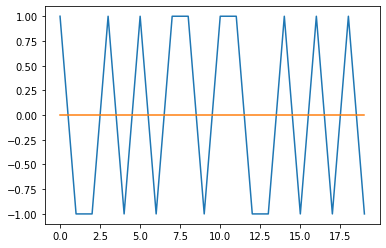

In [150]:
e1 = torch.sign(torch.eig(h).eigenvalues)
plt.plot(e1.detach().cpu()[:20])

In [159]:
torch.sum(e1[:10]>0)

tensor(5, device='cuda:0')

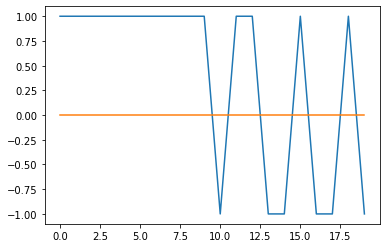

In [155]:
e2 = torch.sign(torch.eig(h2).eigenvalues)
plt.plot(e2.detach().cpu()[:20])

In [160]:
torch.sum(e2[:10]>0)

tensor(10, device='cuda:0')

In [45]:
x.requires_grad = True

In [ ]:
ind1 = y==7
ind1= ind1.detach().cpu()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
loss_p_sample1_1 =  loss_p_sample1[ind1]
ts1_1 = ts1[ind1]
ts2_1 = ts2[ind1]
ax.scatter(xs=ts1_1[acc1[ind1]==1], ys=ts2_1[acc1[ind1]==1], zs=loss_p_sample1_1[acc1[ind1]==1])
ax.scatter(xs=ts1_1[acc1[ind1]==0], ys=ts2_1[acc1[ind1]==0], zs=loss_p_sample1_1[acc1[ind1]==0])
plt.legend(['correct','misclassify'])                   

In [ ]:
ind2 = y==7
ind1= ind2.detach().cpu()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
loss_p_sample2_1 =  loss_p_sample2[ind1]
ts1_1 = ts1[ind1]
ts2_1 = ts2[ind1]
ax.scatter(xs=ts1_1[acc2[ind1]==1], ys=ts2_1[acc2[ind1]==1], zs=loss_p_sample2_1[acc2[ind1]==1])
ax.scatter(xs=ts1_1[acc2[ind1]==0], ys=ts2_1[acc2[ind1]==0], zs=loss_p_sample2_1[acc2[ind1]==0])
plt.legend(['correct','misclassify'])  

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X = ts1_1
Y = ts2_1
X, Y = np.meshgrid(X, Y)
v = loss_p_sample1[ind1].numpy()
Z = np.zeros([1028,1028])
for i in range(1028):
    Z[i,i] = v[i]
    
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 5)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)  

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X = ts1_1
Y = ts2_1
X, Y = np.meshgrid(X, Y)
v = loss_p_sample2[ind1].numpy()
Z = np.zeros([1028,1028])
for i in range(1028):
    Z[i,i] = v[i]
    
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 5)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)    